# Train using balanced subsets of data - 224x224 Redux

### Findings
- Dataset has propensity for flucting validation loss, even with increated dropotuand reduced model layers
- Training at very low LR (1e4) gives more stable results, bult ultimately sub-optimal final results
- Better results achieved using higher LR, and using SaveModelCallback to capture local minima
- Combining multiple top learners gives significantly better results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os
import pickle

import scipy
from scipy.stats import gmean, hmean

In [4]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, \
                          get_accuracy, analyze_confidence, accuracy_vs_threshold, \
                          show_incremental_accuracy,  analyze_low_confidence, \
                          plot_confusion_matrix_thresh, get_val_stats, model_cutter

In [5]:
#from pneumonia_loaders import *

In [6]:
from pneumonia_loaders import show_categories
from pneumonia_new_loader import get_db

In [7]:
from helpers import get_best_stats, show_results, show_results
from helpers import StatsRepo, stats_repo_unit_test
from helpers import _get_learner, _get_interp, analyze_interp, _do_train

# Config

In [8]:
model = models.resnet18
size=224
n_samples=1000    # total number of training samples

In [9]:
all_bs = {225:31, 448:31, 896:7}

In [10]:
data_base = Path()/'data'
model_base = Path('D:/Users/Doug/Models/chest_xray')

all_bs = {224:31, 448:31, 896:7}

In [11]:
prefix = f'd18_{size}'
short_prefix = f'd18_{size}'

data_subdir  = f'chest_xray_{size}'
model_subdir = f'd18_{size}'

if size in [224]:
    path = data_base/data_subdir
    model_dir = (model_base/model_subdir).absolute()
    bs = all_bs[size]
else:
    raise Exception('Unknown size')

In [12]:
bs, model_dir

(31, WindowsPath('D:/Users/Doug/Models/chest_xray/d18_224'))

In [13]:
path.ls()

[WindowsPath('data/chest_xray_224/test'),
 WindowsPath('data/chest_xray_224/train'),
 WindowsPath('data/chest_xray_224/val')]

# Code

In [14]:
def my_transforms():
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    return tfms

In [15]:
def get_params(all_lr=[1e-2, 3e-3, 1e-3], all_cycles=[1,2,4, 8]):
    global short_prefix
    for lr in all_lr:
        for cycles in all_cycles:
            key = f'{short_prefix}_lr_{lr}_cyc_{cycles}'
            yield key, {'cycles':cycles, 'max_lr':lr}

In [16]:
def restore_learner(name, ps=0.5, compute_baseline=True):
    learn = get_learner(ps=ps)
    learn.load(name)
    
    if compute_baseline:
        base = learn.svalidate()
        base = {'loss': base[0], 'error_rate': float(base[1]), 'accuracy': float(base[2])}
    else:
        base = None
    return learn, base

def refine_learner(name, ps=0.8, lr=1e-6, cycles=16, **kwargs):
    learn, base = restore_learner(name, ps=ps)
    print('base:', base)
    learn.unfreeze()
    learn.fit_one_cycle(cycles, max_lr=slice(lr,lr),
                        callbacks=[SaveModelCallback(learn, every='improvement', 
                                   monitor='accuracy', name='best')], **kwargs)
    stats = get_best_stats(learn)
    
    if stats['error_rate'] < base['error_rate']:
        new_name = f'{name}_r_lr{lr}_c{cycles}_ps{ps}'
        print('keeping:', stats)
        return learn, stats, new_name
    else:
        print('ignoring:', stats)
        return None, None, None

# Additional Configuration

###### Initialize stats repo (use prior contents if available)

In [17]:
all_stats = StatsRepo(prefix, force_init=False, verbose=True)

initialializing stats


###### Get Training/Validation/Test dataset for  Normal / Viral / Bacterial

In [18]:
#data = get_db_np(path, size=size, scale=10, tfms=my_transforms())
data, data_test = get_db(path, kind='np', n_samples=n_samples, scale=1, include_test=True,
                  size=size, bs=bs, tfms=my_transforms())
print('Training set:')
show_categories(data.train_ds.y)
print('\nValidation set:')
show_categories(data.valid_ds.y)
print('\nTest set:')
show_categories(data_test.valid_ds.y)

Training set:
  NORMAL    :  1000     50.0%
  PNEUMONIA :  1000     50.0%
  Total     :  2000

Validation set:
  NORMAL    :   117     50.0%
  PNEUMONIA :   117     50.0%
  Total     :   234

Test set:
  NORMAL    :   117     50.0%
  PNEUMONIA :   117     50.0%
  Total     :   234


In [19]:
data

ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,PNEUMONIA,NORMAL,PNEUMONIA
Path: data\chest_xray_224;

Valid: LabelList (234 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,PNEUMONIA,NORMAL,NORMAL,PNEUMONIA
Path: data\chest_xray_224;

Test: None

###### Define configuration specific functions and initialize stats repo (use prior contents if available)

In [20]:
get_learner = partial(_get_learner, db=data, model=model, model_dir=model_dir)
get_learner_test = partial(_get_learner, db=data_test, model=model, model_dir=model_dir)

get_interp = partial(_get_interp, get_learner=get_learner)
get_interp_test = partial(_get_interp, get_learner=get_learner_test)

do_train = partial(_do_train, get_learner=get_learner, stats_repo=all_stats)
do_train_ls = partial(_do_train, get_learner=get_learner, stats_repo=all_stats,
                      use_label_smoothing=True)

In [21]:
import scipy
from scipy.stats import gmean, hmean

def compute_acc(preds, y_true):
    yy = np.argmax(preds, axis=-1)
    return np.mean(yy==y_true)
    

def combine_predictions(all_interp):
    y_true = to_np(all_interp[0][1].y_true)
    all_preds = np.stack([to_np(interp.preds) for _, interp in all_interp])
    
    preds = np.mean(all_preds, axis=0)
    acc_m = compute_acc(preds, y_true) 
    
    preds = np.median(all_preds, axis=0)
    acc_med = compute_acc(preds, y_true)
    
    preds = gmean(all_preds, axis=0)
    acc_g = compute_acc(preds, y_true)
    
    preds = hmean(all_preds, axis=0)
    acc_h = compute_acc(preds, y_true)
    
    print(f'accuracy -- mean: {acc_m:0.3f}   median: {acc_med:0.3f}   gmean: {acc_g:0.3f}   hmean: {acc_h:0.3f}')
    return acc_m, acc_med, acc_g, acc_h

## Various Development Tests
Disabled by default

# Analysis

In [ ]:
# barrier after initialization for notebook restart
assert False

### Basic LR Finder runs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03 
Min loss divided by 10: 1.45E-02
Min numerical gradient: 4.37E-03  (smoothed)
Min numerical gradient: 4.37E-03
Min loss divided by 10: 6.92E-03


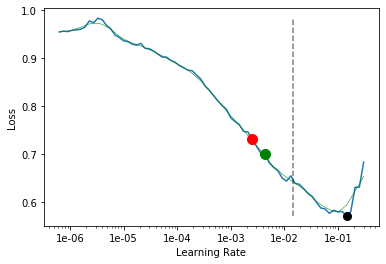

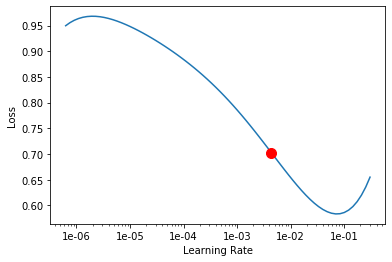

In [22]:
learn = get_learner()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

## Explore Baseline

d18_224_lr_0.01_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.256233,0.531438,0.141026,0.858974,00:31


Better model found at epoch 0 with accuracy value: 0.8589743375778198.


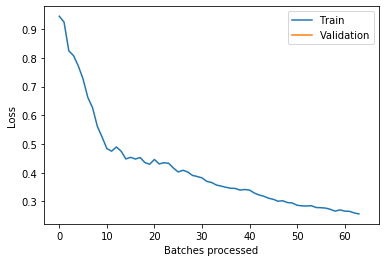

d18_224_lr_0.01_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.303834,0.302048,0.106838,0.893162,00:31
1,0.198499,0.472073,0.136752,0.863248,00:31


Better model found at epoch 0 with accuracy value: 0.8931623697280884.


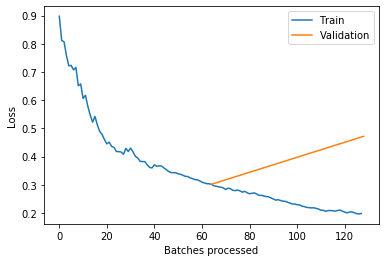

d18_224_lr_0.01_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.299504,0.619042,0.188034,0.811966,00:31
1,0.228433,0.354657,0.119658,0.880342,00:30
2,0.192234,0.606511,0.188034,0.811966,00:31
3,0.158626,0.491657,0.141026,0.858974,00:32


Better model found at epoch 0 with accuracy value: 0.811965823173523.
Better model found at epoch 1 with accuracy value: 0.8803418874740601.


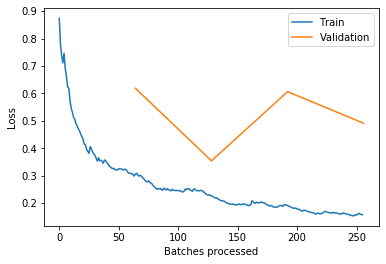

d18_224_lr_0.01_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.314457,0.700444,0.183761,0.816239,00:31
1,0.281386,0.498411,0.166667,0.833333,00:31
2,0.218043,0.414298,0.098291,0.901709,00:31
3,0.181954,0.227657,0.085470,0.914530,00:31
4,0.153239,0.255533,0.081197,0.918803,00:31
5,0.121831,0.221316,0.072650,0.927350,00:31
6,0.110195,0.436405,0.166667,0.833333,00:31
7,0.094039,0.494788,0.179487,0.820513,00:31


Better model found at epoch 0 with accuracy value: 0.8162392973899841.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.
Better model found at epoch 2 with accuracy value: 0.9017093777656555.
Better model found at epoch 3 with accuracy value: 0.9145299196243286.
Better model found at epoch 4 with accuracy value: 0.9188033938407898.
Better model found at epoch 5 with accuracy value: 0.9273504018783569.


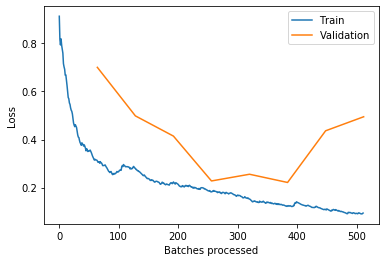

d18_224_lr_0.003_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.294531,0.662725,0.166667,0.833333,00:30


Better model found at epoch 0 with accuracy value: 0.8333333134651184.


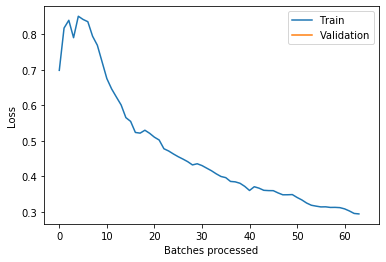

d18_224_lr_0.003_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.352306,0.503304,0.158120,0.841880,00:31
1,0.238922,0.383172,0.119658,0.880342,00:31


Better model found at epoch 0 with accuracy value: 0.8418803215026855.
Better model found at epoch 1 with accuracy value: 0.8803418874740601.


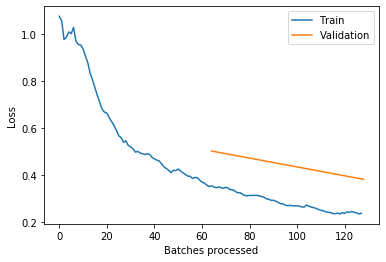

d18_224_lr_0.003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.358985,0.695360,0.179487,0.820513,00:31
1,0.235917,0.322241,0.102564,0.897436,00:31
2,0.181961,0.312398,0.102564,0.897436,00:30
3,0.163633,0.311439,0.094017,0.905983,00:30


Better model found at epoch 0 with accuracy value: 0.8205128312110901.
Better model found at epoch 1 with accuracy value: 0.8974359035491943.
Better model found at epoch 3 with accuracy value: 0.9059829115867615.


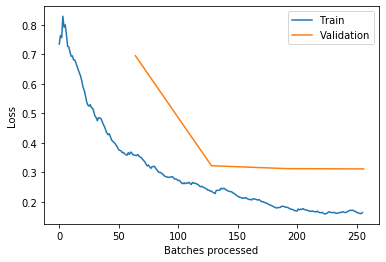

d18_224_lr_0.003_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.380640,0.510261,0.136752,0.863248,00:31
1,0.265178,0.436971,0.123932,0.876068,00:30
2,0.209499,0.330288,0.098291,0.901709,00:30
3,0.179521,0.547385,0.162393,0.837607,00:31
4,0.164511,0.231228,0.085470,0.914530,00:31
5,0.139073,0.408686,0.158120,0.841880,00:30
6,0.125183,0.408794,0.149573,0.850427,00:31
7,0.118860,0.405592,0.145299,0.854701,00:31


Better model found at epoch 0 with accuracy value: 0.8632478713989258.
Better model found at epoch 1 with accuracy value: 0.8760683536529541.
Better model found at epoch 2 with accuracy value: 0.9017093777656555.
Better model found at epoch 4 with accuracy value: 0.9145299196243286.


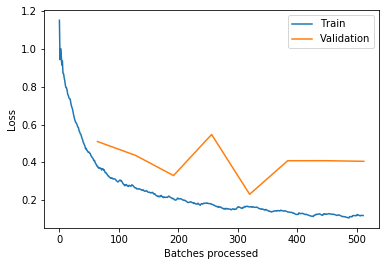

d18_224_lr_0.001_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.348221,0.530634,0.158120,0.841880,00:31


Better model found at epoch 0 with accuracy value: 0.8418803215026855.


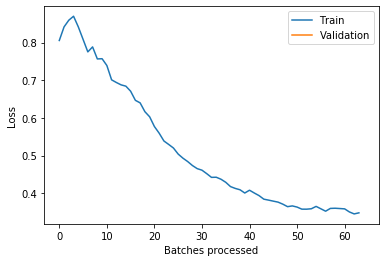

d18_224_lr_0.001_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.422888,0.449398,0.136752,0.863248,00:31
1,0.308434,0.278080,0.089744,0.910256,00:30


Better model found at epoch 0 with accuracy value: 0.8632478713989258.
Better model found at epoch 1 with accuracy value: 0.9102563858032227.


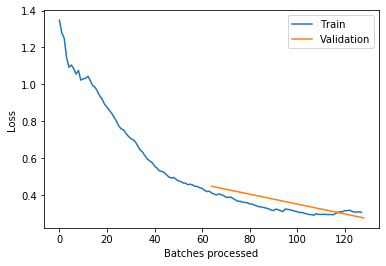

d18_224_lr_0.001_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.460163,0.482971,0.183761,0.816239,00:30
1,0.287130,0.237226,0.089744,0.910256,00:30
2,0.227953,0.322063,0.106838,0.893162,00:31
3,0.212173,0.285109,0.106838,0.893162,00:31


Better model found at epoch 0 with accuracy value: 0.8162392973899841.
Better model found at epoch 1 with accuracy value: 0.9102563858032227.


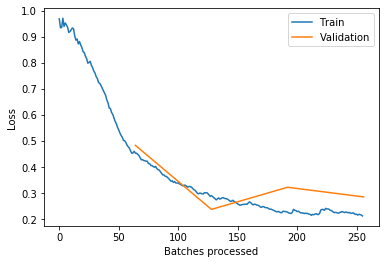

d18_224_lr_0.001_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.551259,0.499079,0.175214,0.824786,00:30
1,0.331409,0.334531,0.111111,0.888889,00:30
2,0.257207,0.344714,0.115385,0.884615,00:30
3,0.221240,0.291173,0.081197,0.918803,00:31
4,0.189742,0.257189,0.076923,0.923077,00:31
5,0.157784,0.323303,0.094017,0.905983,00:31
6,0.150376,0.294973,0.085470,0.914530,00:30
7,0.148842,0.324378,0.089744,0.910256,00:30


Better model found at epoch 0 with accuracy value: 0.8247863054275513.
Better model found at epoch 1 with accuracy value: 0.8888888955116272.
Better model found at epoch 3 with accuracy value: 0.9188033938407898.
Better model found at epoch 4 with accuracy value: 0.9230769276618958.


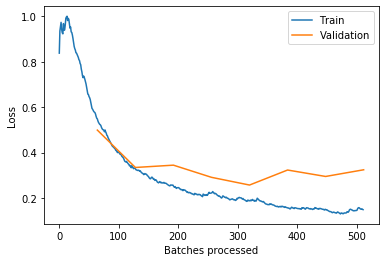

saved stats to: stats\d18_224_stats.p


In [23]:
for key, params in get_params():
    do_train(key, **params)
all_stats.save()

d18_224_lr_0.0003_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.485000,0.391595,0.158120,0.841880,00:30


Better model found at epoch 0 with accuracy value: 0.8418803215026855.


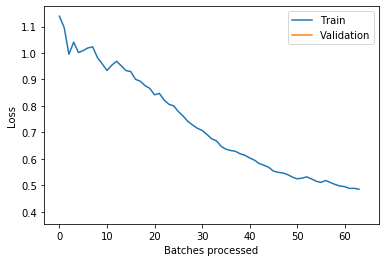

d18_224_lr_0.0003_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.510261,0.539749,0.205128,0.794872,00:31
1,0.337126,0.305768,0.094017,0.905983,00:32


Better model found at epoch 0 with accuracy value: 0.7948718070983887.
Better model found at epoch 1 with accuracy value: 0.9059829115867615.


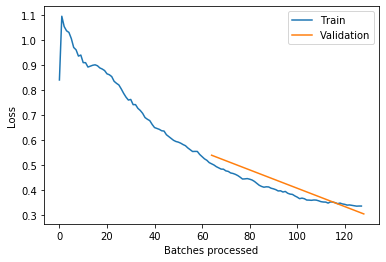

d18_224_lr_0.0003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.662783,0.355906,0.158120,0.841880,00:31
1,0.383870,0.308382,0.115385,0.884615,00:31
2,0.304260,0.321866,0.123932,0.876068,00:31
3,0.272526,0.308894,0.106838,0.893162,00:32


Better model found at epoch 0 with accuracy value: 0.8418803215026855.
Better model found at epoch 1 with accuracy value: 0.8846153616905212.
Better model found at epoch 3 with accuracy value: 0.8931623697280884.


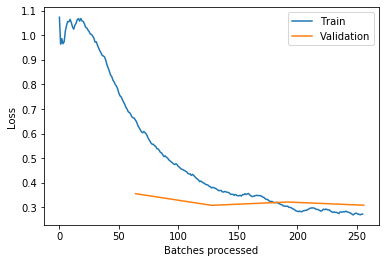

d18_224_lr_0.0003_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.705101,0.465444,0.230769,0.769231,00:30
1,0.417643,0.280161,0.123932,0.876068,00:30
2,0.293460,0.285988,0.106838,0.893162,00:31
3,0.232070,0.285834,0.098291,0.901709,00:31
4,0.221290,0.281766,0.098291,0.901709,00:31
5,0.197746,0.261150,0.081197,0.918803,00:31
6,0.197803,0.262803,0.081197,0.918803,00:30
7,0.211248,0.283102,0.085470,0.914530,00:31


Better model found at epoch 0 with accuracy value: 0.7692307829856873.
Better model found at epoch 1 with accuracy value: 0.8760683536529541.
Better model found at epoch 2 with accuracy value: 0.8931623697280884.
Better model found at epoch 3 with accuracy value: 0.9017093777656555.
Better model found at epoch 5 with accuracy value: 0.9188033938407898.


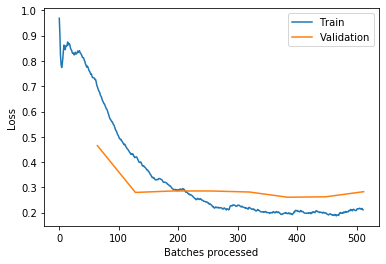

d18_224_lr_0.0001_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.643837,0.492030,0.247863,0.752137,00:30


Better model found at epoch 0 with accuracy value: 0.752136766910553.


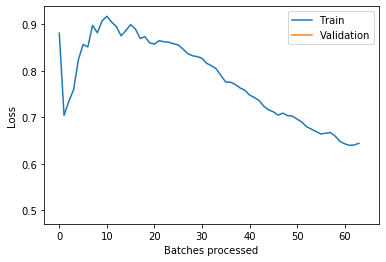

d18_224_lr_0.0001_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.645039,0.440783,0.192308,0.807692,00:30
1,0.454429,0.332549,0.132479,0.867521,00:31


Better model found at epoch 0 with accuracy value: 0.807692289352417.
Better model found at epoch 1 with accuracy value: 0.867521345615387.


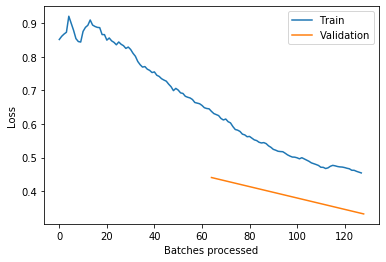

d18_224_lr_0.0001_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.833274,0.490527,0.243590,0.756410,00:30
1,0.524166,0.295150,0.136752,0.863248,00:31
2,0.409231,0.277592,0.119658,0.880342,00:30
3,0.339575,0.287492,0.149573,0.850427,00:30


Better model found at epoch 0 with accuracy value: 0.7564102411270142.
Better model found at epoch 1 with accuracy value: 0.8632478713989258.
Better model found at epoch 2 with accuracy value: 0.8803418874740601.


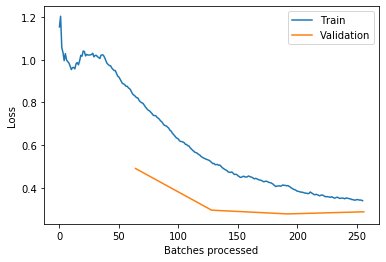

d18_224_lr_0.0001_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.907491,0.599711,0.354701,0.645299,00:30
1,0.637286,0.313527,0.145299,0.854701,00:30
2,0.429887,0.298915,0.128205,0.871795,00:31
3,0.360408,0.284546,0.111111,0.888889,00:31
4,0.299847,0.296885,0.115385,0.884615,00:31
5,0.283929,0.272588,0.102564,0.897436,00:30
6,0.295711,0.274896,0.111111,0.888889,00:31
7,0.275550,0.295614,0.111111,0.888889,00:31


Better model found at epoch 0 with accuracy value: 0.6452991366386414.
Better model found at epoch 1 with accuracy value: 0.8547008633613586.
Better model found at epoch 2 with accuracy value: 0.8717948794364929.
Better model found at epoch 3 with accuracy value: 0.8888888955116272.
Better model found at epoch 5 with accuracy value: 0.8974359035491943.


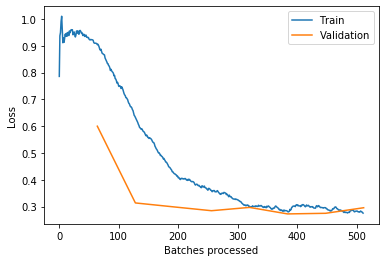

saved stats to: stats\d18_224_stats.p


In [24]:
for key, params in get_params(all_lr=[3e-4, 1e-4]):
    do_train(key, **params)
all_stats.save()

In [25]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.073  med: 0.107   Loss -- best: 0.221  med: 0.307

d18_224_lr_0.01_cyc_8  error_rate: 0.073   accuracy: 0.927   loss:0.2213
d18_224_lr_0.001_cyc_8  error_rate: 0.077   accuracy: 0.923   loss:0.2572
d18_224_lr_0.0003_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2612
d18_224_lr_0.003_cyc_8  error_rate: 0.085   accuracy: 0.915   loss:0.2312
d18_224_lr_0.001_cyc_4  error_rate: 0.090   accuracy: 0.910   loss:0.2372
d18_224_lr_0.001_cyc_2  error_rate: 0.090   accuracy: 0.910   loss:0.2781
d18_224_lr_0.003_cyc_4  error_rate: 0.094   accuracy: 0.906   loss:0.3114
d18_224_lr_0.0003_cyc_2  error_rate: 0.094   accuracy: 0.906   loss:0.3058
d18_224_lr_0.0001_cyc_8  error_rate: 0.103   accuracy: 0.897   loss:0.2726
d18_224_lr_0.0003_cyc_4  error_rate: 0.107   accuracy: 0.893   loss:0.3089


d18_224_lr_0.03_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.484340,0.272602,0.106838,0.893162,00:30


Better model found at epoch 0 with accuracy value: 0.8931623697280884.


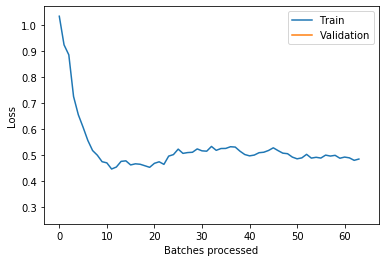

d18_224_lr_0.03_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.481986,0.649627,0.277778,0.722222,00:31
1,0.268304,0.430657,0.183761,0.816239,00:31


Better model found at epoch 0 with accuracy value: 0.7222222089767456.
Better model found at epoch 1 with accuracy value: 0.8162392973899841.


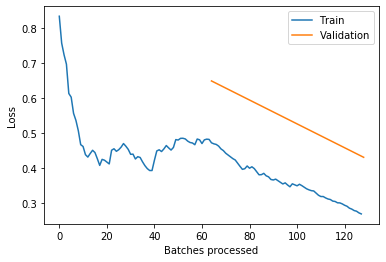

d18_224_lr_0.03_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.341447,1.009042,0.226496,0.773504,00:31
1,0.360640,0.996711,0.294872,0.705128,00:30
2,0.249363,0.670449,0.145299,0.854701,00:31
3,0.178194,0.287237,0.085470,0.914530,00:30


Better model found at epoch 0 with accuracy value: 0.7735042572021484.
Better model found at epoch 2 with accuracy value: 0.8547008633613586.
Better model found at epoch 3 with accuracy value: 0.9145299196243286.


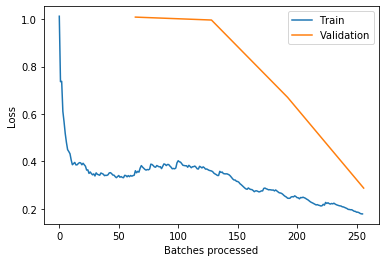

d18_224_lr_0.03_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.323506,1.161585,0.252137,0.747863,00:30
1,0.342468,2.037341,0.457265,0.542735,00:30
2,0.341783,0.684075,0.354701,0.645299,00:31
3,0.254836,0.502082,0.111111,0.888889,00:30
4,0.197647,0.506844,0.153846,0.846154,00:30
5,0.163056,0.170606,0.064103,0.935897,00:30
6,0.136699,0.432822,0.145299,0.854701,00:30
7,0.112939,0.434828,0.119658,0.880342,00:31


Better model found at epoch 0 with accuracy value: 0.747863233089447.
Better model found at epoch 3 with accuracy value: 0.8888888955116272.
Better model found at epoch 5 with accuracy value: 0.9358974099159241.


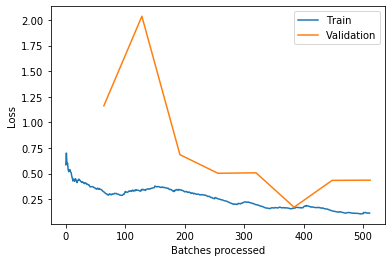

d18_224_lr_0.1_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.830421,0.380197,0.132479,0.867521,00:30


Better model found at epoch 0 with accuracy value: 0.867521345615387.


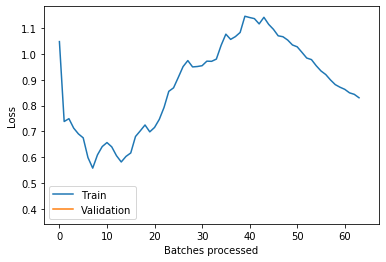

d18_224_lr_0.1_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.097720,3.436102,0.277778,0.722222,00:31
1,0.618773,0.305913,0.136752,0.863248,00:30


Better model found at epoch 0 with accuracy value: 0.7222222089767456.
Better model found at epoch 1 with accuracy value: 0.8632478713989258.


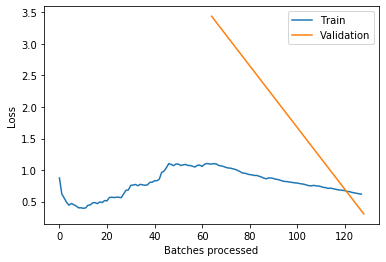

d18_224_lr_0.1_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.774973,4.779387,0.521368,0.478632,00:30
1,1.062815,4.862888,0.465812,0.534188,00:30
2,0.578404,0.289092,0.119658,0.880342,00:30
3,0.347715,0.319555,0.145299,0.854701,00:31


Better model found at epoch 0 with accuracy value: 0.47863247990608215.
Better model found at epoch 1 with accuracy value: 0.5341880321502686.
Better model found at epoch 2 with accuracy value: 0.8803418874740601.


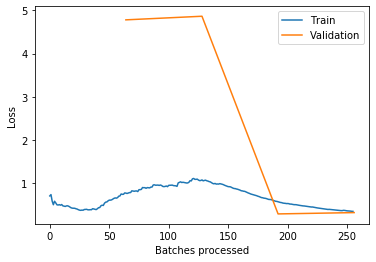

d18_224_lr_0.1_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.369125,1.640451,0.264957,0.735043,00:30
1,0.752548,1.796843,0.401709,0.598291,00:31
2,0.817606,1.422134,0.461538,0.538462,00:30
3,0.621591,0.915990,0.158120,0.841880,00:30
4,0.373773,0.297496,0.119658,0.880342,00:31
5,0.234122,0.570171,0.175214,0.824786,00:30
6,0.166950,0.379649,0.102564,0.897436,00:30
7,0.128538,0.357615,0.115385,0.884615,00:30


Better model found at epoch 0 with accuracy value: 0.7350427508354187.
Better model found at epoch 3 with accuracy value: 0.8418803215026855.
Better model found at epoch 4 with accuracy value: 0.8803418874740601.
Better model found at epoch 6 with accuracy value: 0.8974359035491943.


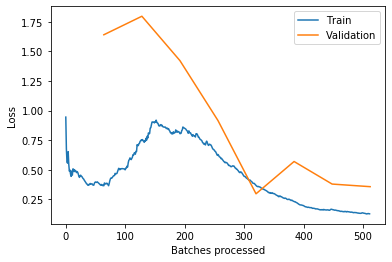

saved stats to: stats\d18_224_stats.p


In [26]:
for key, params in get_params(all_lr=[3e-2, 1e-1]):
    do_train(key, **params)
all_stats.save()

In [27]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.064  med: 0.107   Loss -- best: 0.171  med: 0.306

d18_224_lr_0.03_cyc_8  error_rate: 0.064   accuracy: 0.936   loss:0.1706
d18_224_lr_0.01_cyc_8  error_rate: 0.073   accuracy: 0.927   loss:0.2213
d18_224_lr_0.001_cyc_8  error_rate: 0.077   accuracy: 0.923   loss:0.2572
d18_224_lr_0.0003_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2612
d18_224_lr_0.003_cyc_8  error_rate: 0.085   accuracy: 0.915   loss:0.2312
d18_224_lr_0.03_cyc_4  error_rate: 0.085   accuracy: 0.915   loss:0.2872
d18_224_lr_0.001_cyc_4  error_rate: 0.090   accuracy: 0.910   loss:0.2372
d18_224_lr_0.001_cyc_2  error_rate: 0.090   accuracy: 0.910   loss:0.2781
d18_224_lr_0.003_cyc_4  error_rate: 0.094   accuracy: 0.906   loss:0.3114
d18_224_lr_0.0003_cyc_2  error_rate: 0.094   accuracy: 0.906   loss:0.3058


d18_224_lr_0.001_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.592047,0.400400,0.175214,0.824786,00:31
1,0.379926,0.302062,0.098291,0.901709,00:30
2,0.283887,0.304276,0.098291,0.901709,00:30
3,0.217922,0.214804,0.085470,0.914530,00:30
4,0.197371,0.343295,0.119658,0.880342,00:30
5,0.197640,0.251488,0.098291,0.901709,00:30
6,0.154209,0.356516,0.115385,0.884615,00:30
7,0.161376,0.364518,0.111111,0.888889,00:30
8,0.148426,0.269052,0.098291,0.901709,00:30
9,0.125540,0.353089,0.136752,0.863248,00:30


Better model found at epoch 0 with accuracy value: 0.8247863054275513.
Better model found at epoch 1 with accuracy value: 0.9017093777656555.
Better model found at epoch 3 with accuracy value: 0.9145299196243286.


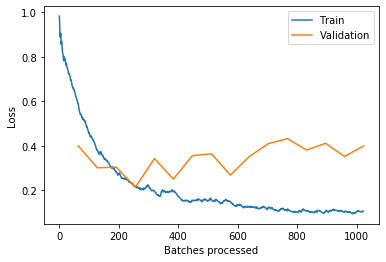

d18_224_lr_0.001_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.078683,0.454477,0.175214,0.824786,00:30
1,0.690585,0.299872,0.111111,0.888889,00:30
2,0.453898,0.356827,0.115385,0.884615,00:30
3,0.344051,0.379875,0.119658,0.880342,00:31
4,0.281656,0.334228,0.106838,0.893162,00:30
5,0.244379,0.397425,0.123932,0.876068,00:30
6,0.193092,0.277352,0.085470,0.914530,00:31
7,0.192754,0.267997,0.081197,0.918803,00:31
8,0.167582,0.311241,0.089744,0.910256,00:30
9,0.159041,0.313536,0.089744,0.910256,00:30


Better model found at epoch 0 with accuracy value: 0.8247863054275513.
Better model found at epoch 1 with accuracy value: 0.8888888955116272.
Better model found at epoch 4 with accuracy value: 0.8931623697280884.
Better model found at epoch 6 with accuracy value: 0.9145299196243286.
Better model found at epoch 7 with accuracy value: 0.9188033938407898.


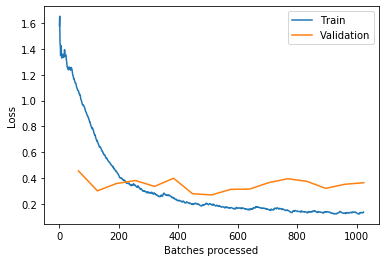

d18_224_lr_0.001_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.167657,0.503990,0.222222,0.777778,00:30
1,0.808984,0.300518,0.119658,0.880342,00:30
2,0.499077,0.325022,0.106838,0.893162,00:30
3,0.340820,0.280259,0.085470,0.914530,00:30
4,0.283023,0.291065,0.085470,0.914530,00:30
5,0.251335,0.352488,0.098291,0.901709,00:31
6,0.216311,0.287099,0.076923,0.923077,00:31
7,0.187487,0.285499,0.085470,0.914530,00:30
8,0.193589,0.334045,0.102564,0.897436,00:30
9,0.169187,0.329139,0.094017,0.905983,00:31


Better model found at epoch 0 with accuracy value: 0.7777777910232544.
Better model found at epoch 1 with accuracy value: 0.8803418874740601.
Better model found at epoch 2 with accuracy value: 0.8931623697280884.
Better model found at epoch 3 with accuracy value: 0.9145299196243286.
Better model found at epoch 6 with accuracy value: 0.9230769276618958.


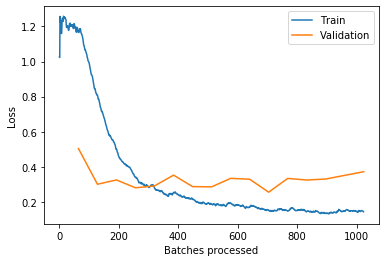

d18_224_lr_0.001_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.576582,0.580985,0.303419,0.696581,00:30
1,1.123194,0.304854,0.123932,0.876068,00:30
2,0.749238,0.323903,0.119658,0.880342,00:30
3,0.525786,0.323028,0.102564,0.897436,00:31
4,0.413765,0.417942,0.111111,0.888889,00:30
5,0.321421,0.374221,0.102564,0.897436,00:30
6,0.263234,0.365634,0.102564,0.897436,00:30
7,0.250879,0.302617,0.102564,0.897436,00:30
8,0.200609,0.363807,0.098291,0.901709,00:30
9,0.186584,0.312990,0.098291,0.901709,00:31


Better model found at epoch 0 with accuracy value: 0.6965811848640442.
Better model found at epoch 1 with accuracy value: 0.8760683536529541.
Better model found at epoch 2 with accuracy value: 0.8803418874740601.
Better model found at epoch 3 with accuracy value: 0.8974359035491943.
Better model found at epoch 8 with accuracy value: 0.9017093777656555.


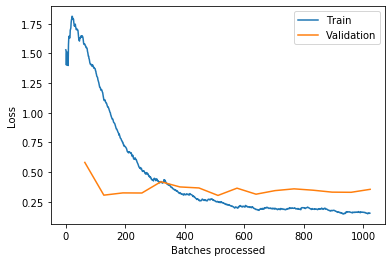

d18_224_lr_0.0003_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.744977,0.601794,0.350427,0.649573,00:30
1,0.557670,0.295590,0.119658,0.880342,00:30
2,0.384202,0.258041,0.089744,0.910256,00:31
3,0.308916,0.255434,0.094017,0.905983,00:30
4,0.269860,0.222573,0.072650,0.927350,00:30
5,0.234311,0.259744,0.085470,0.914530,00:30
6,0.225557,0.216024,0.072650,0.927350,00:30
7,0.201278,0.244283,0.081197,0.918803,00:30
8,0.178278,0.214996,0.059829,0.940171,00:30
9,0.169027,0.277468,0.094017,0.905983,00:30


Better model found at epoch 0 with accuracy value: 0.6495726704597473.
Better model found at epoch 1 with accuracy value: 0.8803418874740601.
Better model found at epoch 2 with accuracy value: 0.9102563858032227.
Better model found at epoch 4 with accuracy value: 0.9273504018783569.
Better model found at epoch 8 with accuracy value: 0.94017094373703.


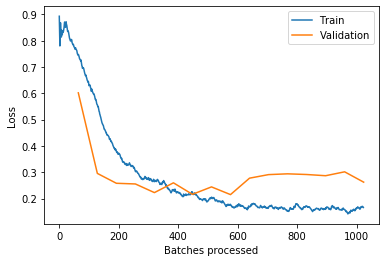

d18_224_lr_0.0003_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.255009,0.576044,0.303419,0.696581,00:30
1,1.007705,0.324392,0.141026,0.858974,00:30
2,0.727356,0.256641,0.115385,0.884615,00:31
3,0.503021,0.252595,0.115385,0.884615,00:30
4,0.390788,0.261821,0.106838,0.893162,00:30
5,0.353676,0.275702,0.098291,0.901709,00:30
6,0.307117,0.287840,0.098291,0.901709,00:30
7,0.270740,0.280777,0.089744,0.910256,00:30
8,0.262505,0.365420,0.111111,0.888889,00:30
9,0.239737,0.348894,0.098291,0.901709,00:30


Better model found at epoch 0 with accuracy value: 0.6965811848640442.
Better model found at epoch 1 with accuracy value: 0.8589743375778198.
Better model found at epoch 2 with accuracy value: 0.8846153616905212.
Better model found at epoch 4 with accuracy value: 0.8931623697280884.
Better model found at epoch 5 with accuracy value: 0.9017093777656555.
Better model found at epoch 7 with accuracy value: 0.9102563858032227.
Better model found at epoch 13 with accuracy value: 0.9188033938407898.


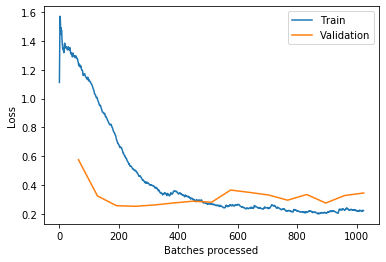

d18_224_lr_0.0003_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.265208,0.659783,0.346154,0.653846,00:30
1,1.093172,0.402117,0.188034,0.811966,00:31
2,0.791183,0.305016,0.115385,0.884615,00:30
3,0.597234,0.314624,0.115385,0.884615,00:30
4,0.457581,0.301540,0.098291,0.901709,00:31
5,0.377816,0.313734,0.081197,0.918803,00:31
6,0.348126,0.329919,0.089744,0.910256,00:31
7,0.313647,0.320927,0.089744,0.910256,00:31
8,0.318533,0.339384,0.094017,0.905983,00:31
9,0.288049,0.310942,0.094017,0.905983,00:31


Better model found at epoch 0 with accuracy value: 0.6538461446762085.
Better model found at epoch 1 with accuracy value: 0.811965823173523.
Better model found at epoch 2 with accuracy value: 0.8846153616905212.
Better model found at epoch 4 with accuracy value: 0.9017093777656555.
Better model found at epoch 5 with accuracy value: 0.9188033938407898.


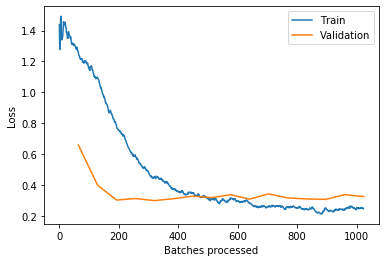

d18_224_lr_0.0003_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.818810,0.881261,0.512821,0.487179,00:30
1,1.588892,0.411345,0.153846,0.846154,00:31
2,1.267067,0.267995,0.123932,0.876068,00:31
3,0.931086,0.263420,0.111111,0.888889,00:31
4,0.662636,0.283506,0.098291,0.901709,00:31
5,0.562653,0.282263,0.094017,0.905983,00:31
6,0.455434,0.304086,0.085470,0.914530,00:30
7,0.395775,0.298477,0.081197,0.918803,00:31
8,0.383572,0.280593,0.081197,0.918803,00:31
9,0.354421,0.302433,0.072650,0.927350,00:31


Better model found at epoch 0 with accuracy value: 0.4871794879436493.
Better model found at epoch 1 with accuracy value: 0.8461538553237915.
Better model found at epoch 2 with accuracy value: 0.8760683536529541.
Better model found at epoch 3 with accuracy value: 0.8888888955116272.
Better model found at epoch 4 with accuracy value: 0.9017093777656555.
Better model found at epoch 5 with accuracy value: 0.9059829115867615.
Better model found at epoch 6 with accuracy value: 0.9145299196243286.
Better model found at epoch 7 with accuracy value: 0.9188033938407898.
Better model found at epoch 9 with accuracy value: 0.9273504018783569.


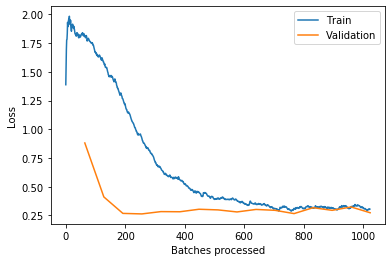

d18_224_lr_0.0001_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.974048,0.766604,0.478632,0.521368,00:31
1,0.807227,0.488075,0.235043,0.764957,00:31
2,0.594461,0.309626,0.119658,0.880342,00:31
3,0.422152,0.265841,0.094017,0.905983,00:31
4,0.336848,0.243283,0.085470,0.914530,00:31
5,0.289467,0.257319,0.094017,0.905983,00:31
6,0.271579,0.273186,0.085470,0.914530,00:31
7,0.254666,0.255468,0.081197,0.918803,00:31
8,0.246144,0.258041,0.081197,0.918803,00:31
9,0.226506,0.250841,0.081197,0.918803,00:31


Better model found at epoch 0 with accuracy value: 0.5213675498962402.
Better model found at epoch 1 with accuracy value: 0.7649572491645813.
Better model found at epoch 2 with accuracy value: 0.8803418874740601.
Better model found at epoch 3 with accuracy value: 0.9059829115867615.
Better model found at epoch 4 with accuracy value: 0.9145299196243286.
Better model found at epoch 7 with accuracy value: 0.9188033938407898.
Better model found at epoch 13 with accuracy value: 0.9230769276618958.


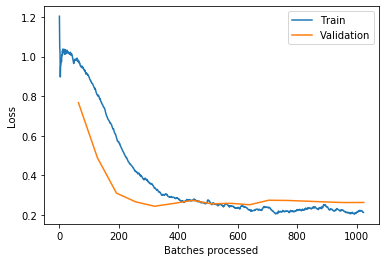

d18_224_lr_0.0001_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.235800,0.679621,0.414530,0.585470,00:31
1,1.113798,0.483480,0.235043,0.764957,00:31
2,0.924371,0.348004,0.141026,0.858974,00:31
3,0.724642,0.286093,0.128205,0.871795,00:31
4,0.582622,0.277987,0.123932,0.876068,00:31
5,0.493482,0.270141,0.119658,0.880342,00:31
6,0.436052,0.283003,0.111111,0.888889,00:31
7,0.410401,0.286396,0.102564,0.897436,00:31
8,0.374352,0.286924,0.089744,0.910256,00:31
9,0.359957,0.310653,0.098291,0.901709,00:31


Better model found at epoch 0 with accuracy value: 0.5854700803756714.
Better model found at epoch 1 with accuracy value: 0.7649572491645813.
Better model found at epoch 2 with accuracy value: 0.8589743375778198.
Better model found at epoch 3 with accuracy value: 0.8717948794364929.
Better model found at epoch 4 with accuracy value: 0.8760683536529541.
Better model found at epoch 5 with accuracy value: 0.8803418874740601.
Better model found at epoch 6 with accuracy value: 0.8888888955116272.
Better model found at epoch 7 with accuracy value: 0.8974359035491943.
Better model found at epoch 8 with accuracy value: 0.9102563858032227.
Better model found at epoch 10 with accuracy value: 0.9145299196243286.


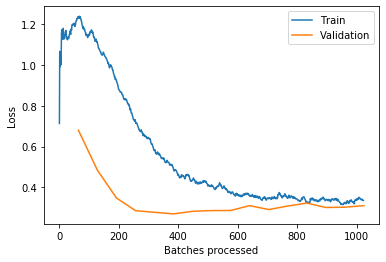

d18_224_lr_0.0001_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.270604,0.619223,0.337607,0.662393,00:31
1,1.194999,0.500019,0.213675,0.786325,00:31
2,1.104524,0.378968,0.162393,0.837607,00:31
3,0.929655,0.325629,0.141026,0.858974,00:31
4,0.748904,0.302843,0.128205,0.871795,00:31
5,0.592734,0.317446,0.119658,0.880342,00:31
6,0.544335,0.315220,0.123932,0.876068,00:31
7,0.459080,0.331455,0.123932,0.876068,00:31
8,0.426673,0.329585,0.115385,0.884615,00:32
9,0.433020,0.315711,0.106838,0.893162,00:31


Better model found at epoch 0 with accuracy value: 0.6623931527137756.
Better model found at epoch 1 with accuracy value: 0.7863247990608215.
Better model found at epoch 2 with accuracy value: 0.8376068472862244.
Better model found at epoch 3 with accuracy value: 0.8589743375778198.
Better model found at epoch 4 with accuracy value: 0.8717948794364929.
Better model found at epoch 5 with accuracy value: 0.8803418874740601.
Better model found at epoch 8 with accuracy value: 0.8846153616905212.
Better model found at epoch 9 with accuracy value: 0.8931623697280884.
Better model found at epoch 14 with accuracy value: 0.8974359035491943.


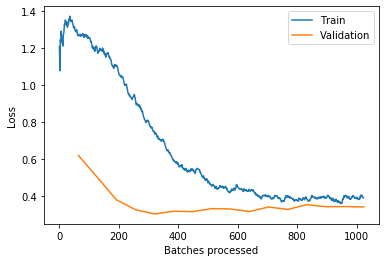

d18_224_lr_0.0001_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.433573,0.612610,0.350427,0.649573,00:31
1,1.313341,0.518784,0.286325,0.713675,00:31
2,1.225799,0.440608,0.209402,0.790598,00:30
3,1.095095,0.354554,0.175214,0.824786,00:30
4,0.912925,0.308393,0.136752,0.863248,00:31
5,0.799976,0.309040,0.123932,0.876068,00:31
6,0.730329,0.294049,0.115385,0.884615,00:31
7,0.636807,0.291114,0.111111,0.888889,00:31
8,0.577314,0.307688,0.115385,0.884615,00:31
9,0.512511,0.300118,0.111111,0.888889,00:32


Better model found at epoch 0 with accuracy value: 0.6495726704597473.
Better model found at epoch 1 with accuracy value: 0.7136752009391785.
Better model found at epoch 2 with accuracy value: 0.7905982732772827.
Better model found at epoch 3 with accuracy value: 0.8247863054275513.
Better model found at epoch 4 with accuracy value: 0.8632478713989258.
Better model found at epoch 5 with accuracy value: 0.8760683536529541.
Better model found at epoch 6 with accuracy value: 0.8846153616905212.
Better model found at epoch 7 with accuracy value: 0.8888888955116272.
Better model found at epoch 11 with accuracy value: 0.8974359035491943.


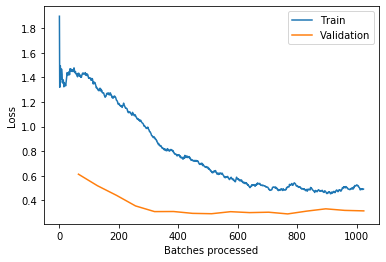

saved stats to: stats\d18_224_stats.p


In [28]:
for key, params in get_params(all_cycles=[16], all_lr=[1e-3, 3e-4, 1e-4]):
    for ps in [0.5, 0.8, 0.85, 0.9]:
        do_train(key, ps=ps, **params)
all_stats.save()

In [29]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.060  med: 0.100   Loss -- best: 0.171  med: 0.297

d18_224_lr_0.0003_cyc_16_ps_0.5  error_rate: 0.060   accuracy: 0.940   loss:0.2150
d18_224_lr_0.03_cyc_8  error_rate: 0.064   accuracy: 0.936   loss:0.1706
d18_224_lr_0.01_cyc_8  error_rate: 0.073   accuracy: 0.927   loss:0.2213
d18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.073   accuracy: 0.927   loss:0.3024
d18_224_lr_0.001_cyc_8  error_rate: 0.077   accuracy: 0.923   loss:0.2572
d18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.077   accuracy: 0.923   loss:0.2871
d18_224_lr_0.0001_cyc_16_ps_0.5  error_rate: 0.077   accuracy: 0.923   loss:0.2650
d18_224_lr_0.0003_cyc_8  error_rate: 0.081   accuracy: 0.919   loss:0.2612
d18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.081   accuracy: 0.919   loss:0.2680
d18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.081   accuracy: 0.919   loss:0.2753


### Focus on specific configurations

18_224cut_lr_0.01_cyc_8

d18_224_lr_0.01_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.302318,0.518160,0.136752,0.863248,00:31
1,0.251748,0.201595,0.076923,0.923077,00:31
2,0.220246,0.534043,0.192308,0.807692,00:31
3,0.202015,0.402385,0.153846,0.846154,00:31
4,0.152587,0.414879,0.136752,0.863248,00:32
5,0.117246,0.191207,0.055556,0.944444,00:32
6,0.106833,0.359998,0.106838,0.893162,00:31
7,0.079296,0.382186,0.111111,0.888889,00:31


Better model found at epoch 0 with accuracy value: 0.8632478713989258.
Better model found at epoch 1 with accuracy value: 0.9230769276618958.
Better model found at epoch 5 with accuracy value: 0.9444444179534912.


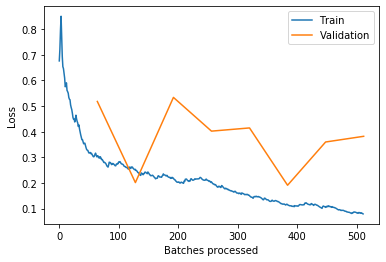

d18_224_lr_0.01_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.320851,0.964091,0.213675,0.786325,00:31
1,0.272500,0.358507,0.102564,0.897436,00:31
2,0.231760,0.391375,0.115385,0.884615,00:31
3,0.183897,1.365767,0.346154,0.653846,00:31
4,0.161825,0.456002,0.102564,0.897436,00:31
5,0.143746,0.188309,0.055556,0.944444,00:31
6,0.103829,0.548512,0.153846,0.846154,00:31
7,0.108623,0.473699,0.136752,0.863248,00:31


Better model found at epoch 0 with accuracy value: 0.7863247990608215.
Better model found at epoch 1 with accuracy value: 0.8974359035491943.
Better model found at epoch 5 with accuracy value: 0.9444444179534912.


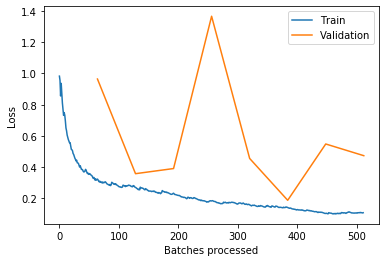

d18_224_lr_0.01_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.309896,0.736494,0.179487,0.820513,00:31
1,0.241304,0.218139,0.076923,0.923077,00:31
2,0.199929,0.134364,0.038462,0.961538,00:31
3,0.177987,0.143633,0.059829,0.940171,00:31
4,0.145988,0.523550,0.132479,0.867521,00:31
5,0.121407,0.256186,0.068376,0.931624,00:31
6,0.111295,0.337506,0.089744,0.910256,00:31
7,0.103524,0.285652,0.081197,0.918803,00:31


Better model found at epoch 0 with accuracy value: 0.8205128312110901.
Better model found at epoch 1 with accuracy value: 0.9230769276618958.
Better model found at epoch 2 with accuracy value: 0.9615384340286255.


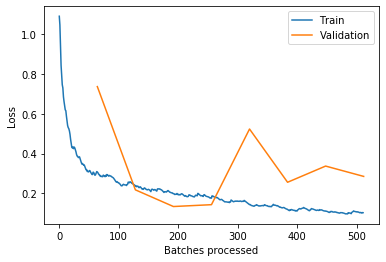

d18_224_lr_0.01_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.336549,0.459014,0.158120,0.841880,00:31
1,0.232389,0.672773,0.247863,0.752137,00:32
2,0.225669,0.395862,0.119658,0.880342,00:32
3,0.204129,0.336018,0.128205,0.871795,00:31
4,0.158252,0.338800,0.106838,0.893162,00:32
5,0.138929,0.427536,0.149573,0.850427,00:31
6,0.132017,0.578716,0.196581,0.803419,00:31
7,0.097700,0.544405,0.175214,0.824786,00:31


Better model found at epoch 0 with accuracy value: 0.8418803215026855.
Better model found at epoch 2 with accuracy value: 0.8803418874740601.
Better model found at epoch 4 with accuracy value: 0.8931623697280884.


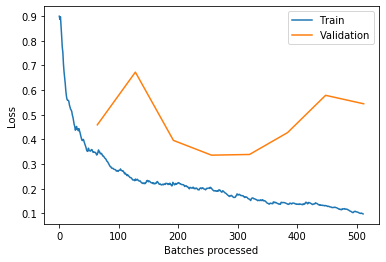

d18_224_lr_0.01_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.335147,0.474470,0.115385,0.884615,00:31
1,0.249084,0.646000,0.188034,0.811966,00:31
2,0.210026,1.795960,0.393162,0.606838,00:31
3,0.211249,0.288588,0.123932,0.876068,00:31
4,0.172459,0.635910,0.209402,0.790598,00:31
5,0.137287,0.398580,0.149573,0.850427,00:31
6,0.119011,0.746303,0.239316,0.760684,00:31
7,0.104841,0.612499,0.200855,0.799145,00:31


Better model found at epoch 0 with accuracy value: 0.8846153616905212.


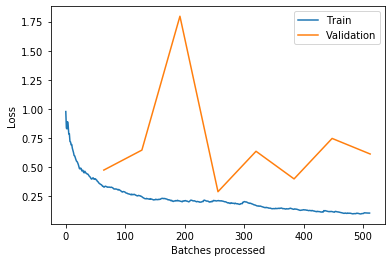

d18_224_lr_0.01_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.355568,0.430285,0.115385,0.884615,00:31
1,0.270473,0.180540,0.072650,0.927350,00:31
2,0.215929,0.420724,0.106838,0.893162,00:32
3,0.186267,0.524579,0.128205,0.871795,00:31
4,0.145862,0.452681,0.102564,0.897436,00:31
5,0.131064,0.407481,0.145299,0.854701,00:31
6,0.116066,0.494390,0.141026,0.858974,00:31
7,0.093365,0.426570,0.136752,0.863248,00:31


Better model found at epoch 0 with accuracy value: 0.8846153616905212.
Better model found at epoch 1 with accuracy value: 0.9273504018783569.


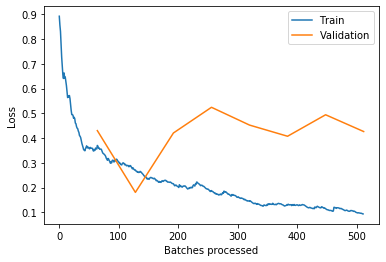

d18_224_lr_0.01_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.326080,0.490341,0.111111,0.888889,00:31
1,0.231245,0.302992,0.094017,0.905983,00:31
2,0.197077,0.386481,0.098291,0.901709,00:32
3,0.191330,1.156944,0.358974,0.641026,00:31
4,0.163198,0.358385,0.119658,0.880342,00:32
5,0.133424,0.395387,0.162393,0.837607,00:32
6,0.118048,0.417513,0.136752,0.863248,00:31
7,0.092275,0.476275,0.153846,0.846154,00:32


Better model found at epoch 0 with accuracy value: 0.8888888955116272.
Better model found at epoch 1 with accuracy value: 0.9059829115867615.


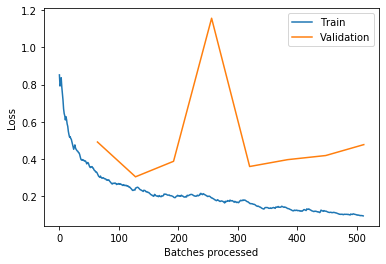

d18_224_lr_0.01_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.331517,0.438531,0.119658,0.880342,00:31
1,0.257892,0.320753,0.115385,0.884615,00:31
2,0.240264,0.527981,0.136752,0.863248,00:31
3,0.201191,0.186577,0.068376,0.931624,00:31
4,0.172108,0.786739,0.243590,0.756410,00:31
5,0.145443,0.703817,0.213675,0.786325,00:31
6,0.114591,0.406002,0.128205,0.871795,00:31
7,0.095392,0.633021,0.192308,0.807692,00:31


Better model found at epoch 0 with accuracy value: 0.8803418874740601.
Better model found at epoch 1 with accuracy value: 0.8846153616905212.
Better model found at epoch 3 with accuracy value: 0.9316239356994629.


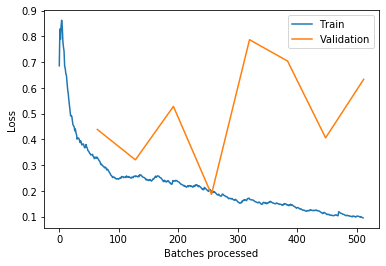

d18_224_lr_0.01_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.305384,0.652745,0.153846,0.846154,00:30
1,0.246399,0.271575,0.089744,0.910256,00:31
2,0.216993,0.601348,0.158120,0.841880,00:31
3,0.192059,0.288695,0.128205,0.871795,00:31
4,0.191958,0.555595,0.136752,0.863248,00:31
5,0.152895,0.362926,0.102564,0.897436,00:31
6,0.119309,0.400114,0.123932,0.876068,00:31
7,0.102464,0.402224,0.132479,0.867521,00:31


Better model found at epoch 0 with accuracy value: 0.8461538553237915.
Better model found at epoch 1 with accuracy value: 0.9102563858032227.


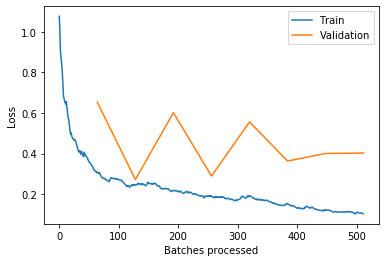

d18_224_lr_0.01_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.314991,0.474569,0.145299,0.854701,00:31
1,0.234205,0.572442,0.158120,0.841880,00:31
2,0.217028,0.951350,0.294872,0.705128,00:31
3,0.193504,1.505589,0.260684,0.739316,00:31
4,0.158120,0.918397,0.282051,0.717949,00:31
5,0.129647,0.468446,0.153846,0.846154,00:31
6,0.112700,0.395348,0.119658,0.880342,00:31
7,0.097268,0.448159,0.136752,0.863248,00:31


Better model found at epoch 0 with accuracy value: 0.8547008633613586.
Better model found at epoch 6 with accuracy value: 0.8803418874740601.


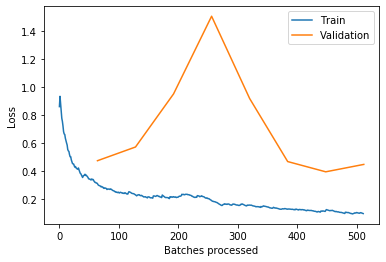

saved stats to: stats\d18_224_stats.p


In [30]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [31]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.038  med: 0.094   Loss -- best: 0.134  med: 0.291

d18_224_lr_0.01_cyc_8_i2  error_rate: 0.038   accuracy: 0.962   loss:0.1344
d18_224_lr_0.01_cyc_8_i0  error_rate: 0.056   accuracy: 0.944   loss:0.1912
d18_224_lr_0.01_cyc_8_i1  error_rate: 0.056   accuracy: 0.944   loss:0.1883
d18_224_lr_0.0003_cyc_16_ps_0.5  error_rate: 0.060   accuracy: 0.940   loss:0.2150
d18_224_lr_0.03_cyc_8  error_rate: 0.064   accuracy: 0.936   loss:0.1706
d18_224_lr_0.01_cyc_8_i7  error_rate: 0.068   accuracy: 0.932   loss:0.1866
d18_224_lr_0.01_cyc_8  error_rate: 0.073   accuracy: 0.927   loss:0.2213
d18_224_lr_0.01_cyc_8_i5  error_rate: 0.073   accuracy: 0.927   loss:0.1805
d18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.073   accuracy: 0.927   loss:0.3024
d18_224_lr_0.001_cyc_8  error_rate: 0.077   accuracy: 0.923   loss:0.2572


d18_224_lr_0.01_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.311275,0.245232,0.076923,0.923077,00:31
1,0.251346,0.373411,0.132479,0.867521,00:31
2,0.192874,0.413334,0.145299,0.854701,00:31
3,0.133812,0.437981,0.158120,0.841880,00:30


Better model found at epoch 0 with accuracy value: 0.9230769276618958.


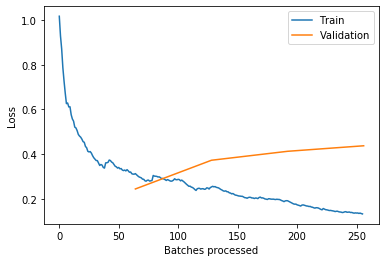

d18_224_lr_0.01_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.324414,0.334244,0.111111,0.888889,00:31
1,0.250021,0.984096,0.247863,0.752137,00:31
2,0.191312,0.734916,0.200855,0.799145,00:31
3,0.137341,0.562119,0.162393,0.837607,00:31


Better model found at epoch 0 with accuracy value: 0.8888888955116272.


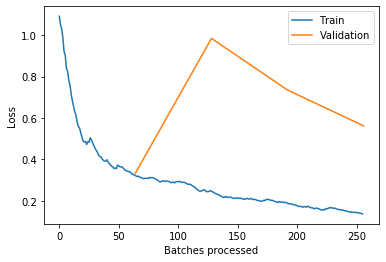

d18_224_lr_0.01_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.328331,0.288727,0.098291,0.901709,00:31
1,0.241093,0.391116,0.115385,0.884615,00:30
2,0.181926,0.830797,0.235043,0.764957,00:31
3,0.136280,0.447010,0.136752,0.863248,00:31


Better model found at epoch 0 with accuracy value: 0.9017093777656555.


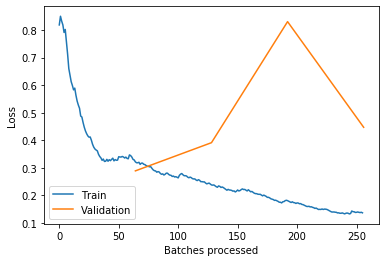

d18_224_lr_0.01_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.313379,1.065781,0.299145,0.700855,00:31
1,0.247517,0.264766,0.106838,0.893162,00:31
2,0.175915,0.448035,0.123932,0.876068,00:31
3,0.131912,0.371025,0.102564,0.897436,00:31


Better model found at epoch 0 with accuracy value: 0.7008547186851501.
Better model found at epoch 1 with accuracy value: 0.8931623697280884.
Better model found at epoch 3 with accuracy value: 0.8974359035491943.


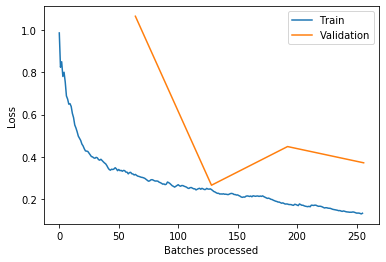

d18_224_lr_0.01_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.307328,0.381011,0.132479,0.867521,00:31
1,0.227030,0.522323,0.145299,0.854701,00:31
2,0.220230,0.248699,0.094017,0.905983,00:31
3,0.160753,0.415662,0.132479,0.867521,00:31


Better model found at epoch 0 with accuracy value: 0.867521345615387.
Better model found at epoch 2 with accuracy value: 0.9059829115867615.


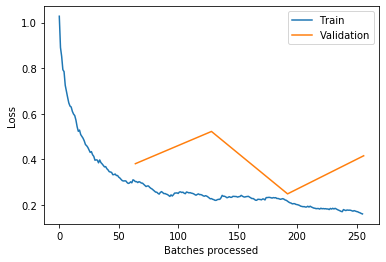

d18_224_lr_0.01_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.313291,0.728011,0.226496,0.773504,00:31
1,0.232016,0.366970,0.149573,0.850427,00:31
2,0.191355,0.247607,0.072650,0.927350,00:31
3,0.148324,0.350760,0.111111,0.888889,00:31


Better model found at epoch 0 with accuracy value: 0.7735042572021484.
Better model found at epoch 1 with accuracy value: 0.8504273295402527.
Better model found at epoch 2 with accuracy value: 0.9273504018783569.


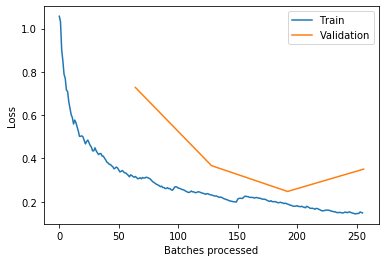

d18_224_lr_0.01_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.330662,0.395946,0.119658,0.880342,00:31
1,0.263399,0.512718,0.153846,0.846154,00:31
2,0.191030,0.233347,0.076923,0.923077,00:31
3,0.137866,0.649430,0.205128,0.794872,00:31


Better model found at epoch 0 with accuracy value: 0.8803418874740601.
Better model found at epoch 2 with accuracy value: 0.9230769276618958.


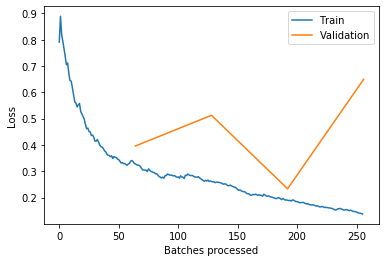

d18_224_lr_0.01_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.352040,1.060635,0.337607,0.662393,00:31
1,0.240762,0.526325,0.158120,0.841880,00:31
2,0.188945,0.330750,0.106838,0.893162,00:31
3,0.160801,0.292296,0.098291,0.901709,00:31


Better model found at epoch 0 with accuracy value: 0.6623931527137756.
Better model found at epoch 1 with accuracy value: 0.8418803215026855.
Better model found at epoch 2 with accuracy value: 0.8931623697280884.
Better model found at epoch 3 with accuracy value: 0.9017093777656555.


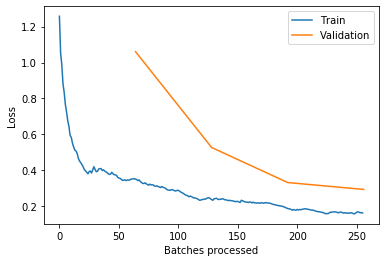

d18_224_lr_0.01_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.308132,0.231855,0.085470,0.914530,00:31
1,0.233467,1.290393,0.367521,0.632479,00:31
2,0.187028,0.662658,0.252137,0.747863,00:31
3,0.141501,0.597028,0.196581,0.803419,00:31


Better model found at epoch 0 with accuracy value: 0.9145299196243286.


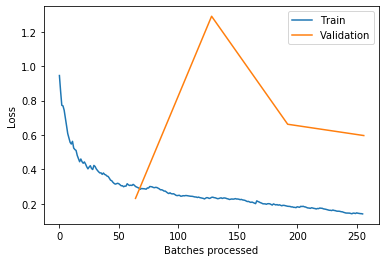

d18_224_lr_0.01_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.302985,0.359727,0.106838,0.893162,00:31
1,0.241351,0.179034,0.064103,0.935897,00:31
2,0.188079,0.400993,0.098291,0.901709,00:31
3,0.153088,0.408639,0.102564,0.897436,00:31


Better model found at epoch 0 with accuracy value: 0.8931623697280884.
Better model found at epoch 1 with accuracy value: 0.9358974099159241.


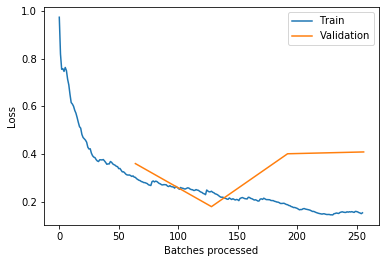

saved stats to: stats\d18_224_stats.p


In [32]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [33]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.038  med: 0.094   Loss -- best: 0.134  med: 0.289

d18_224_lr_0.01_cyc_8_i2  error_rate: 0.038   accuracy: 0.962   loss:0.1344
d18_224_lr_0.01_cyc_8_i0  error_rate: 0.056   accuracy: 0.944   loss:0.1912
d18_224_lr_0.01_cyc_8_i1  error_rate: 0.056   accuracy: 0.944   loss:0.1883
d18_224_lr_0.0003_cyc_16_ps_0.5  error_rate: 0.060   accuracy: 0.940   loss:0.2150
d18_224_lr_0.03_cyc_8  error_rate: 0.064   accuracy: 0.936   loss:0.1706
d18_224_lr_0.01_cyc_4_i9  error_rate: 0.064   accuracy: 0.936   loss:0.1790
d18_224_lr_0.01_cyc_8_i7  error_rate: 0.068   accuracy: 0.932   loss:0.1866
d18_224_lr_0.01_cyc_8  error_rate: 0.073   accuracy: 0.927   loss:0.2213
d18_224_lr_0.01_cyc_8_i5  error_rate: 0.073   accuracy: 0.927   loss:0.1805
d18_224_lr_0.01_cyc_4_i5  error_rate: 0.073   accuracy: 0.927   loss:0.2476


d18_224_lr_0.01_cyc_12_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.326547,0.876820,0.230769,0.769231,00:31
1,0.250716,0.250181,0.072650,0.927350,00:31
2,0.224163,0.170858,0.064103,0.935897,00:30
3,0.209578,0.487964,0.200855,0.799145,00:31
4,0.194210,1.035433,0.243590,0.756410,00:31
5,0.169143,0.338736,0.115385,0.884615,00:30
6,0.132280,0.786567,0.239316,0.760684,00:31
7,0.118004,1.021422,0.294872,0.705128,00:31
8,0.111283,0.376779,0.132479,0.867521,00:31
9,0.095786,0.445797,0.141026,0.858974,00:31


Better model found at epoch 0 with accuracy value: 0.7692307829856873.
Better model found at epoch 1 with accuracy value: 0.9273504018783569.
Better model found at epoch 2 with accuracy value: 0.9358974099159241.


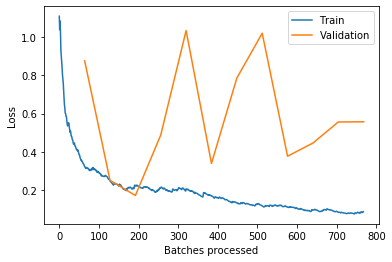

d18_224_lr_0.01_cyc_12_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.342933,0.771692,0.183761,0.816239,00:31
1,0.244676,0.536976,0.162393,0.837607,00:31
2,0.225887,0.453820,0.128205,0.871795,00:31
3,0.212104,1.071014,0.380342,0.619658,00:31
4,0.188618,0.530870,0.128205,0.871795,00:30
5,0.182178,0.389524,0.102564,0.897436,00:31
6,0.142902,0.377114,0.115385,0.884615,00:31
7,0.122017,0.245359,0.068376,0.931624,00:31
8,0.113404,0.479157,0.136752,0.863248,00:31
9,0.093435,0.448886,0.145299,0.854701,00:31


Better model found at epoch 0 with accuracy value: 0.8162392973899841.
Better model found at epoch 1 with accuracy value: 0.8376068472862244.
Better model found at epoch 2 with accuracy value: 0.8717948794364929.
Better model found at epoch 5 with accuracy value: 0.8974359035491943.
Better model found at epoch 7 with accuracy value: 0.9316239356994629.


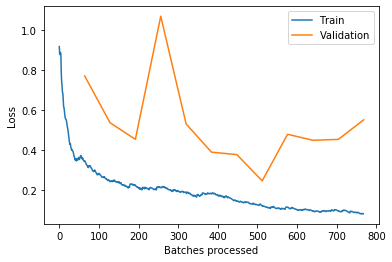

d18_224_lr_0.01_cyc_12_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.361440,0.514271,0.149573,0.850427,00:31
1,0.273932,0.224903,0.081197,0.918803,00:31
2,0.214504,1.105865,0.243590,0.756410,00:31
3,0.207099,0.791991,0.196581,0.803419,00:31
4,0.177024,0.306612,0.081197,0.918803,00:31
5,0.174182,0.292395,0.076923,0.923077,00:31
6,0.140777,0.461824,0.162393,0.837607,00:31
7,0.127703,0.483539,0.183761,0.816239,00:31
8,0.116668,0.422944,0.183761,0.816239,00:31
9,0.116869,0.287170,0.115385,0.884615,00:31


Better model found at epoch 0 with accuracy value: 0.8504273295402527.
Better model found at epoch 1 with accuracy value: 0.9188033938407898.
Better model found at epoch 5 with accuracy value: 0.9230769276618958.


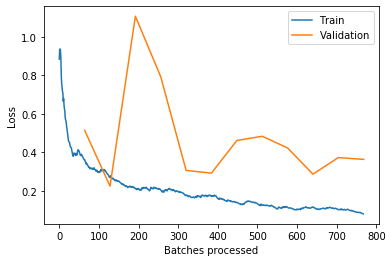

d18_224_lr_0.01_cyc_12_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.334267,0.677654,0.188034,0.811966,00:30
1,0.248639,0.184208,0.072650,0.927350,00:31
2,0.204823,0.185001,0.047009,0.952991,00:31
3,0.196330,0.448054,0.115385,0.884615,00:31
4,0.181652,0.419706,0.111111,0.888889,00:31
5,0.174146,0.321970,0.098291,0.901709,00:31
6,0.153507,0.449659,0.162393,0.837607,00:31
7,0.115134,1.280586,0.367521,0.632479,00:31
8,0.102090,0.315154,0.094017,0.905983,00:31
9,0.089567,0.634866,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.811965823173523.
Better model found at epoch 1 with accuracy value: 0.9273504018783569.
Better model found at epoch 2 with accuracy value: 0.9529914259910583.


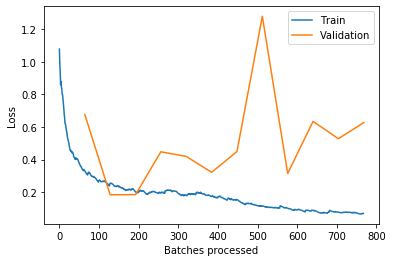

d18_224_lr_0.01_cyc_12_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.299404,1.044077,0.243590,0.756410,00:31
1,0.220161,0.369335,0.089744,0.910256,00:31
2,0.197035,1.083803,0.273504,0.726496,00:31
3,0.209481,0.184291,0.072650,0.927350,00:31
4,0.198848,0.581373,0.235043,0.764957,00:31
5,0.172943,0.647601,0.158120,0.841880,00:31
6,0.148677,1.645614,0.427350,0.572650,00:31
7,0.150681,0.255280,0.089744,0.910256,00:31
8,0.111573,0.374016,0.132479,0.867521,00:31
9,0.101829,0.439715,0.149573,0.850427,00:31


Better model found at epoch 0 with accuracy value: 0.7564102411270142.
Better model found at epoch 1 with accuracy value: 0.9102563858032227.
Better model found at epoch 3 with accuracy value: 0.9273504018783569.


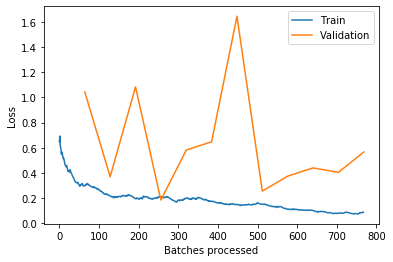

d18_224_lr_0.01_cyc_12_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.310137,0.585663,0.158120,0.841880,00:31
1,0.252861,0.229565,0.081197,0.918803,00:31
2,0.237914,0.186739,0.085470,0.914530,00:31
3,0.226717,0.663560,0.230769,0.769231,00:31
4,0.191117,0.241900,0.089744,0.910256,00:31
5,0.163724,0.799500,0.247863,0.752137,00:31
6,0.170434,0.743463,0.252137,0.747863,00:31
7,0.126196,0.388511,0.123932,0.876068,00:31
8,0.114743,0.333729,0.119658,0.880342,00:31
9,0.095948,0.501973,0.136752,0.863248,00:31


Better model found at epoch 0 with accuracy value: 0.8418803215026855.
Better model found at epoch 1 with accuracy value: 0.9188033938407898.


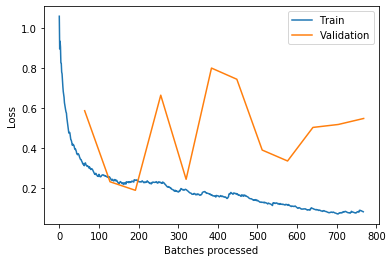

d18_224_lr_0.01_cyc_12_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.355164,0.871430,0.213675,0.786325,00:31
1,0.247669,0.299941,0.111111,0.888889,00:31
2,0.223442,0.369687,0.115385,0.884615,00:32
3,0.220509,0.641278,0.136752,0.863248,00:31
4,0.197273,0.291223,0.128205,0.871795,00:31
5,0.165820,0.959795,0.286325,0.713675,00:31
6,0.150038,0.206388,0.076923,0.923077,00:30
7,0.137327,0.271422,0.076923,0.923077,00:31
8,0.115603,0.457504,0.149573,0.850427,00:31
9,0.103353,0.852635,0.260684,0.739316,00:31


Better model found at epoch 0 with accuracy value: 0.7863247990608215.
Better model found at epoch 1 with accuracy value: 0.8888888955116272.
Better model found at epoch 6 with accuracy value: 0.9230769276618958.


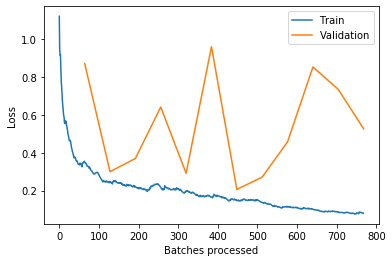

d18_224_lr_0.01_cyc_12_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.324330,0.521237,0.128205,0.871795,00:31
1,0.245691,0.183825,0.055556,0.944444,00:31
2,0.198018,0.368016,0.089744,0.910256,00:31
3,0.193997,0.528526,0.170940,0.829060,00:30
4,0.183032,0.201706,0.064103,0.935897,00:31
5,0.144020,0.152631,0.042735,0.957265,00:31
6,0.137614,0.410462,0.136752,0.863248,00:31
7,0.121857,0.432114,0.115385,0.884615,00:31
8,0.124144,0.587249,0.175214,0.824786,00:31
9,0.106729,0.792182,0.200855,0.799145,00:32


Better model found at epoch 0 with accuracy value: 0.8717948794364929.
Better model found at epoch 1 with accuracy value: 0.9444444179534912.
Better model found at epoch 5 with accuracy value: 0.9572649598121643.


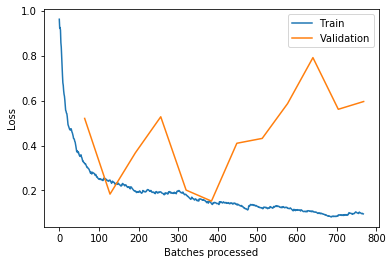

d18_224_lr_0.01_cyc_12_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.326062,0.416371,0.106838,0.893162,00:31
1,0.245004,0.359401,0.106838,0.893162,00:31
2,0.193123,0.293577,0.102564,0.897436,00:32
3,0.192563,0.380612,0.123932,0.876068,00:31
4,0.183868,0.130499,0.021368,0.978632,00:31
5,0.149330,1.203354,0.299145,0.700855,00:31
6,0.144370,0.210139,0.076923,0.923077,00:30
7,0.129919,0.326451,0.102564,0.897436,00:31
8,0.112090,0.266162,0.076923,0.923077,00:31
9,0.108549,0.378973,0.128205,0.871795,00:31


Better model found at epoch 0 with accuracy value: 0.8931623697280884.
Better model found at epoch 2 with accuracy value: 0.8974359035491943.
Better model found at epoch 4 with accuracy value: 0.9786324501037598.


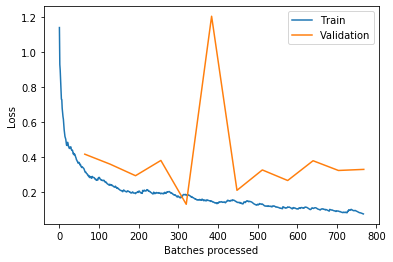

d18_224_lr_0.01_cyc_12_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.306409,0.632503,0.183761,0.816239,00:31
1,0.245096,0.302668,0.111111,0.888889,00:31
2,0.215963,0.464108,0.166667,0.833333,00:31
3,0.223778,0.236550,0.085470,0.914530,00:31
4,0.189214,0.230739,0.047009,0.952991,00:31
5,0.162036,0.718120,0.162393,0.837607,00:31
6,0.153318,0.339811,0.106838,0.893162,00:31
7,0.133263,0.465479,0.153846,0.846154,00:31
8,0.115683,0.572953,0.170940,0.829060,00:31
9,0.090209,0.439280,0.136752,0.863248,00:31


Better model found at epoch 0 with accuracy value: 0.8162392973899841.
Better model found at epoch 1 with accuracy value: 0.8888888955116272.
Better model found at epoch 3 with accuracy value: 0.9145299196243286.
Better model found at epoch 4 with accuracy value: 0.9529914259910583.


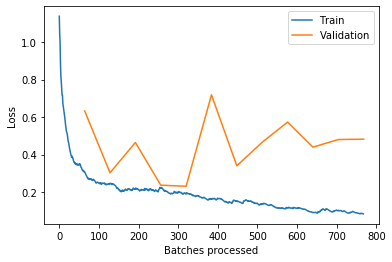

saved stats to: stats\d18_224_stats.p


In [34]:
for i in range(10):
    for key, params in get_params(all_cycles=[12], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [35]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.021  med: 0.088   Loss -- best: 0.130  med: 0.278

d18_224_lr_0.01_cyc_12_i8  error_rate: 0.021   accuracy: 0.979   loss:0.1305
d18_224_lr_0.01_cyc_8_i2  error_rate: 0.038   accuracy: 0.962   loss:0.1344
d18_224_lr_0.01_cyc_12_i7  error_rate: 0.043   accuracy: 0.957   loss:0.1526
d18_224_lr_0.01_cyc_12_i3  error_rate: 0.047   accuracy: 0.953   loss:0.1850
d18_224_lr_0.01_cyc_12_i9  error_rate: 0.047   accuracy: 0.953   loss:0.2307
d18_224_lr_0.01_cyc_8_i0  error_rate: 0.056   accuracy: 0.944   loss:0.1912
d18_224_lr_0.01_cyc_8_i1  error_rate: 0.056   accuracy: 0.944   loss:0.1883
d18_224_lr_0.0003_cyc_16_ps_0.5  error_rate: 0.060   accuracy: 0.940   loss:0.2150
d18_224_lr_0.03_cyc_8  error_rate: 0.064   accuracy: 0.936   loss:0.1706
d18_224_lr_0.01_cyc_4_i9  error_rate: 0.064   accuracy: 0.936   loss:0.1790


d18_224_lr_0.02_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.299852,0.544459,0.153846,0.846154,00:31
1,0.285789,0.553134,0.230769,0.769231,00:31
2,0.293341,0.637434,0.209402,0.790598,00:31
3,0.241196,0.349206,0.115385,0.884615,00:31
4,0.183146,0.372818,0.111111,0.888889,00:31
5,0.137438,0.365626,0.111111,0.888889,00:31
6,0.119966,0.465851,0.175214,0.824786,00:31
7,0.113120,0.647374,0.230769,0.769231,00:32


Better model found at epoch 0 with accuracy value: 0.8461538553237915.
Better model found at epoch 3 with accuracy value: 0.8846153616905212.
Better model found at epoch 4 with accuracy value: 0.8888888955116272.


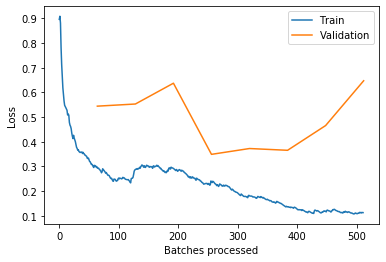

d18_224_lr_0.02_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.323197,1.282261,0.286325,0.713675,00:31
1,0.283836,0.253976,0.102564,0.897436,00:31
2,0.267600,0.334501,0.123932,0.876068,00:31
3,0.212583,1.066750,0.286325,0.713675,00:31
4,0.184342,0.147631,0.055556,0.944444,00:31
5,0.139173,0.632623,0.179487,0.820513,00:31
6,0.125549,0.425586,0.149573,0.850427,00:31
7,0.102360,0.595376,0.213675,0.786325,00:31


Better model found at epoch 0 with accuracy value: 0.7136752009391785.
Better model found at epoch 1 with accuracy value: 0.8974359035491943.
Better model found at epoch 4 with accuracy value: 0.9444444179534912.


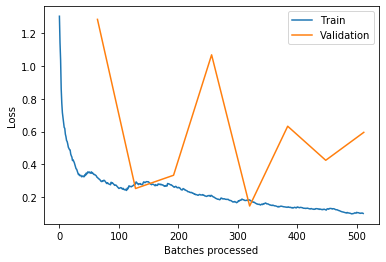

d18_224_lr_0.02_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.304807,0.459191,0.128205,0.871795,00:31
1,0.256790,0.312845,0.064103,0.935897,00:31
2,0.237109,0.225422,0.098291,0.901709,00:31
3,0.206476,0.428018,0.158120,0.841880,00:31
4,0.199602,0.328021,0.128205,0.871795,00:31
5,0.165490,0.596343,0.183761,0.816239,00:31
6,0.117899,0.556244,0.153846,0.846154,00:31
7,0.101627,0.546490,0.162393,0.837607,00:31


Better model found at epoch 0 with accuracy value: 0.8717948794364929.
Better model found at epoch 1 with accuracy value: 0.9358974099159241.


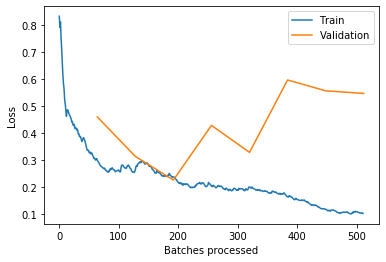

d18_224_lr_0.02_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.291165,0.229517,0.064103,0.935897,00:31
1,0.241075,0.308772,0.085470,0.914530,00:31
2,0.247263,0.247101,0.068376,0.931624,00:31
3,0.219362,0.194034,0.076923,0.923077,00:31
4,0.174870,0.646388,0.217949,0.782051,00:31
5,0.146154,0.246122,0.072650,0.927350,00:31
6,0.118782,0.462618,0.166667,0.833333,00:31
7,0.088220,0.562614,0.188034,0.811966,00:32


Better model found at epoch 0 with accuracy value: 0.9358974099159241.


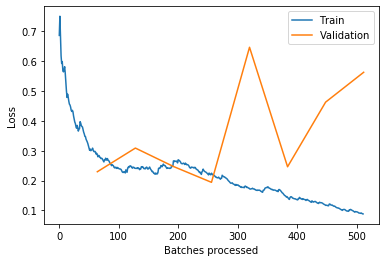

d18_224_lr_0.02_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.298849,0.366719,0.102564,0.897436,00:31
1,0.267800,1.362762,0.341880,0.658120,00:30
2,0.290732,0.366812,0.132479,0.867521,00:31
3,0.250461,0.355624,0.149573,0.850427,00:31
4,0.195801,0.343861,0.115385,0.884615,00:31
5,0.156477,0.403061,0.153846,0.846154,00:31
6,0.128933,0.236668,0.072650,0.927350,00:31
7,0.106213,0.311236,0.106838,0.893162,00:31


Better model found at epoch 0 with accuracy value: 0.8974359035491943.
Better model found at epoch 6 with accuracy value: 0.9273504018783569.


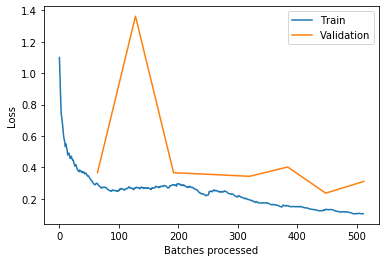

d18_224_lr_0.02_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.295397,0.580581,0.183761,0.816239,00:31
1,0.251815,1.667380,0.252137,0.747863,00:31
2,0.296452,0.212186,0.089744,0.910256,00:31
3,0.226918,0.266506,0.119658,0.880342,00:31
4,0.204014,0.167795,0.068376,0.931624,00:31
5,0.169560,0.578554,0.175214,0.824786,00:31
6,0.133822,0.494641,0.162393,0.837607,00:31
7,0.125494,0.472939,0.153846,0.846154,00:31


Better model found at epoch 0 with accuracy value: 0.8162392973899841.
Better model found at epoch 2 with accuracy value: 0.9102563858032227.
Better model found at epoch 4 with accuracy value: 0.9316239356994629.


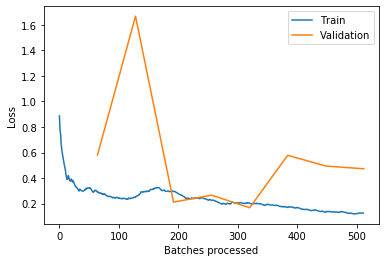

d18_224_lr_0.02_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.342969,0.397191,0.115385,0.884615,00:32
1,0.315592,0.207949,0.081197,0.918803,00:31
2,0.273048,1.168671,0.414530,0.585470,00:31
3,0.250362,0.144521,0.072650,0.927350,00:31
4,0.200233,0.370012,0.106838,0.893162,00:31
5,0.163380,0.350025,0.158120,0.841880,00:31
6,0.134225,0.300871,0.111111,0.888889,00:31
7,0.115277,0.273498,0.098291,0.901709,00:31


Better model found at epoch 0 with accuracy value: 0.8846153616905212.
Better model found at epoch 1 with accuracy value: 0.9188033938407898.
Better model found at epoch 3 with accuracy value: 0.9273504018783569.


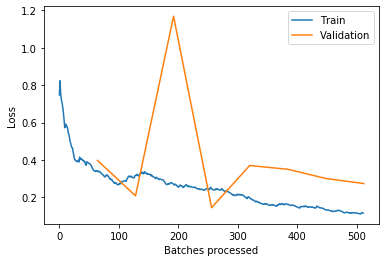

d18_224_lr_0.02_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.326033,0.436329,0.115385,0.884615,00:31
1,0.279002,0.382187,0.132479,0.867521,00:31
2,0.257060,0.232091,0.094017,0.905983,00:31
3,0.217686,0.323412,0.106838,0.893162,00:31
4,0.169092,0.499121,0.136752,0.863248,00:31
5,0.144286,0.357861,0.098291,0.901709,00:31
6,0.113261,0.364840,0.119658,0.880342,00:31
7,0.104312,0.471775,0.145299,0.854701,00:31


Better model found at epoch 0 with accuracy value: 0.8846153616905212.
Better model found at epoch 2 with accuracy value: 0.9059829115867615.


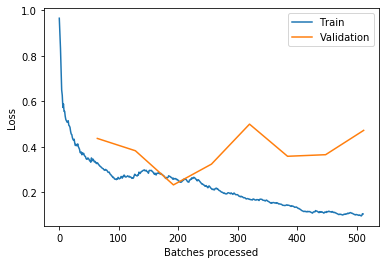

d18_224_lr_0.02_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.301683,0.515509,0.141026,0.858974,00:31
1,0.245880,0.347462,0.153846,0.846154,00:31


Better model found at epoch 0 with accuracy value: 0.8589743375778198.


In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[16], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[3e-3, 1e-3]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[3e-3,1e-3]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

In [ ]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[2e-2, 1e-2]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
show_results(all_stats.get(), limit=10)

## Summary of Results

In [ ]:
for key in [None, 'lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12',  'cyc_16', 
            '_m', 'ls', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, show_details=False)

In [ ]:
show_results(all_stats.get(), limit=10)

In [ ]:
for key in ['lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12', 'cyc_16', 
            '_m', 'ls', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, limit=6)
    print('\n')

In [ ]:
assert False

## Inference

- try composite of 4 learners
- try test-time augmentation

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
name = top_results[0]
print(name)

In [ ]:
interp = get_interp(name)
print(f'\n{name} Validation tta=False')
analyze_interp(interp)

In [ ]:
interp = get_interp_test(name)
print(f'\n{name} Test tta=False')
analyze_interp(interp)

#### Use TTA

In [ ]:
interp = get_interp(name, use_tta=True)
print(f'\n{name} Validation tta=True')
analyze_interp(interp)

In [ ]:
interp = get_interp_test(name, use_tta=True)
print(f'\n{name} Test tta=True')
analyze_interp(interp)

### Composite for Validation based on accuracy

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

#### Show Individual - for Validation dataset

In [ ]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

### Composite for Validation based on loss

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

### Composite for Test based on accuracy

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

#### Individual results for top 4

In [ ]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

#### Try again using TTA

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

### Composite for Test based on loss

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

#### Try again using TTA

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

In [ ]:
assert False

## Experiment with fine tuning classifier

In [ ]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(2e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-5))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=2)
stats, new_name

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=8)
stats, new_name

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=8)
    foo.append([1, stats])
foo

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=16)
    foo.append([1, stats])
    print('\n')
foo